In [9]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">

# Part 1: Understanding the difference between PCA and Least Squares

</div>

In [199]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.testing import assert_approx_equal
import pandas as pd

<div class="custom-assignment-text">

## Goal

Both PCA and least squares regression can be viewed as algorithms for inferring (linear) relationships among data variables. In this part of the mini-project, you will develop some intuition for the differences between these two approaches, and an understanding of the settings that are better suited to using PCA or better suited to using the least squares fit.

## Description

The high level bit is that PCA is useful when there is a set of latent (hidden/underlying) variables, and all the coordinates of your data are linear combinations (plus noise) of those variables. The least squares fit is useful when you have direct access to the independent variables, so any noisy coordinates are linear combinations (plus noise) of known variables.

We will consider a simple example with two variables, $x$ and $y$, where the true relationship between the variables is $y = 2x$. Our goal is to recover this relationship—namely, recover the coefficient “2”. In subpart (b), we consider the setting where our data consists of the actual values of $x$, and noisy estimates of $y$. In subpart (c), we consider the case where our data consists of noisy measurements of both $x$ and $y$. For each part, we will evaluate the quality of the relationship recovered by PCA, and that recovered by standard least squares regression.

As a reminder, least squares regression minimizes the squared error of the dependent variable from its prediction. Namely, given $(x_i, y_i)$ pairs, least squares returns the line $l(x)$ that minimizes $\sum_i (y_i − l(x_i))^2$.

## Exercises

(a) Warm-up (do not submit):
* Write a routine `pca-recover` that takes a vector $X$ of $x_i$’s and a vector $Y$ of $y_i$’s and returns the slope of the first component of the PCA (namely, the second coordinate divided by the first).
* Write a routine `ls-recover` that takes $X$ and $Y$ and returns the slope of the least squares fit. (Hint: since $X$ is one-dimensional, this takes a particularly simple form: $\langle X−\overline{X}, Y − \overline{Y} \rangle / || X−\overline{X} ||_2^2$, where $\overline{X}$ is the mean value of $X$.)
* Set $X = [.001, .002, .003, . . . , 1]$ and $Y = 2X$. Make sure both routines return 2.

</div>

In [271]:
def pca(X, scale=True):
    """X: each column should be observations of a variable
    scale: True if columns should be scaled to the same units
    returns: eigenvectors of covariance matrix of X, ordered by eigenvalue descending"""
    
    # subtract column means so that each column is centered at the origin
    normed = X - np.mean(X, 0)
    # divide by standard deviation so that columns have uniform units
    if scale:
        normed /= np.std(normed, 0)
        
    cov = normed.T @ normed
    # e.g. 1000 rows x 2 columns should yield a 2x2 matrix
    assert cov.shape == (X.shape[1], X.shape[1])
    
    # `eigh` sorts the returned eigenvalues (ascending); it's also faster than plain `eig`
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    
    return np.flip(eigen_vectors, axis=0)

def pca_recover(X, Y):
    """X and Y are 1-D vectors; returns the slope of the least-squares fit"""
    assert len(X.shape) == 1
    assert len(Y.shape) == 1
    mat = np.column_stack((X.T,Y.T))
    components = pca(mat, False)
    return components[0][1] / components[0][0]

def _test_pca_recover():
    X = np.arange(.001, 1.001, .001)
    Y = 2 * X
    assert_approx_equal(pca_recover(X, Y), 2)
    
_test_pca_recover()
ok()

In [184]:
def ls_recover(X, Y):
    """X and Y are 1-D vectors; returns the slope of the least-squares fit"""
    assert len(X.shape) == 1
    assert len(Y.shape) == 1
    X_centered = X - np.mean(X)
    Y_centered = Y - np.mean(Y)
    return np.inner(X_centered, Y_centered) / np.linalg.norm(X_centered)**2

def _test_ls_recover():
    X = np.arange(.001, 1.001, .001)
    Y = 2 * X
    assert_approx_equal(ls_recover(X, Y), 2)

_test_ls_recover()
ok()

<div class="custom-assignment-text">

(b) (4 points) Say the elements of X and Y were chosen identically and independently at random (e.g.
every element is uniformly distributed in the square [0, 1]×[0, 1]). What would PCA recover, and what
would LS recover?

</div>

The slope of `ls_recover` gives the average linear change in Y with respect to X. With well-spread values, the value will be close to 0. However, if the Y values are uniformly biased high or low, or if the bias changes near the center of the X values before changing back again (like a quadratic function), the slope will still be roughly 0, so it's not a very useful measure in this regard. `pca_recover` will, in the limit, always return a slope closer to $\pm 1$ ($45^{\circ}$) when the X and Y data distributions are more similar.

It took a while to come up with this interpretation. To aid in building intuition, it helped to generate a low number (3-5) random X and Y values, and plot them along with the slopes provided by `pca_recover` and `ls_recover`:

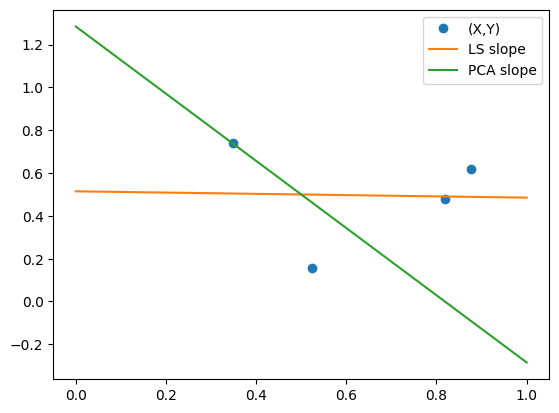

In [278]:
def one_b():
    X = np.random.uniform(0,1,size=4)
    Y = np.random.uniform(0,1,size=4)
    ls_slope = ls_recover(X, Y)
    pca_slope = pca_recover(X, Y)
    
    fig, ax = plt.subplots()
    ax.plot(X, Y, marker="o", linestyle="None", label="(X,Y)")
    ax.plot([0, 1], [.5-ls_slope/2, .5+ls_slope/2], label="LS slope")
    ax.plot([0, 1], [.5-pca_slope/2, .5+pca_slope/2], label="PCA slope")
    ax.legend(loc="best")
    
one_b()

<div class="custom-assignment-text">

(c) (5 points) We first consider the case where $x$ is an independent (a.k.a. explanatory) variable, and we get noisy measurements of $y$. Fix $X = [x_1, x_2,..., x_{1000}] = [.001, .002, .003,..., 1]$. For a given noise level $c$, let $\hat{y}_i ∼ 2x_i + \mathcal{N}(0, c) = 2i/1000 + \mathcal{N}(0, c)$, and $\hat{Y} = [\hat{y}_1, \hat{y}_2,..., \hat{y}_{1000}]$. Make a scatter plot with $c$ on the horizontal axis, and the output of pca-recover and ls-recover on the vertical axis. For each $c$ in $[0, 0.05, 0.1,..., .45, .5]$, take a sample $\hat{Y}$, plot the output of pca-recover as a red dot, and the output of ls-recover as a blue dot. Repeat 30 times. You should end up with a plot of 660 dots, in 11 columns of 60, half red and half blue.

Hint: in both numpy and matlab, $randn(1000)*σ$ generates an array of 1000 independent samples
from $\mathcal{N}(0, σ^2)$. In python you’ll also need to add `from numpy.random import randn`.

</div>